# LangChain using GPT4ALL Embedding

Lixiao Yang\
8/31/2023

- langchain.llms.GPT4All: https://api.python.langchain.com/en/latest/llms/langchain.llms.gpt4all.GPT4All.html#langchain.llms.gpt4all.GPT4All
- langchain.embeddings.GPT4AllEmbedding: https://api.python.langchain.com/en/latest/embeddings/langchain.embeddings.gpt4all.GPT4AllEmbeddings.html
- langchain.chain.RetrivalQA: https://api.python.langchain.com/en/latest/chains/langchain.chains.retrieval_qa.base.RetrievalQA.html#langchain.chains.retrieval_qa.base.RetrievalQA

In [1]:
!pip install gpt4all langchain chromadb

Defaulting to user installation because normal site-packages is not writeable


## Step 1. Load

In [2]:
from langchain.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://en.wikipedia.org/wiki/FIFA")
data = loader.load()

## Step 2. Split

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 0)
all_splits = text_splitter.split_documents(data)

## Step 3. Store

In [4]:
from langchain.embeddings import GPT4AllEmbeddings
from langchain.vectorstores import Chroma

vectorstore = Chroma.from_documents(documents=all_splits, embedding=GPT4AllEmbeddings())

Found model file at  C:\\\\Users\\\\24075\\\\.cache\\\\gpt4all\\ggml-all-MiniLM-L6-v2-f16.bin


## Step 4. Retrieve

In [5]:
question = "Which team won the 2022 world cup?"
docs = vectorstore.similarity_search(question)
len(docs)

4

Session will crash for "go deeper".


In [ ]:
'''
from langchain.retrievers import SVMRetriever

svm_retriever = SVMRetriever.from_documents(all_splits,GPT4AllEmbeddings())
docs_svm=svm_retriever.get_relevant_documents(question)
len(docs_svm)
'''

In [1]:
'''
import logging

from langchain.chat_models import ChatOpenAI
from langchain.retrievers.multi_query import MultiQueryRetriever

logging.basicConfig()
logging.getLogger('langchain.retrievers.multi_query').setLevel(logging.INFO)

retriever_from_llm = MultiQueryRetriever.from_llm(retriever=vectorstore.as_retriever(),
                                                  llm=ChatOpenAI(temperature=0))
unique_docs = retriever_from_llm.get_relevant_documents(query=question)
len(unique_docs)
'''

"\nimport logging\n\nfrom langchain.chat_models import ChatOpenAI\nfrom langchain.retrievers.multi_query import MultiQueryRetriever\n\nlogging.basicConfig()\nlogging.getLogger('langchain.retrievers.multi_query').setLevel(logging.INFO)\n\nretriever_from_llm = MultiQueryRetriever.from_llm(retriever=vectorstore.as_retriever(),\n                                                  llm=ChatOpenAI(temperature=0))\nunique_docs = retriever_from_llm.get_relevant_documents(query=question)\nlen(unique_docs)\n"

## Step 5. Generate

In [11]:
from langchain.llms import GPT4All
from langchain.chains import RetrievalQA

gpt4all_falcon_model = "C:/Users/24075/AppData/Local/nomic.ai/GPT4All/ggml-model-gpt4all-falcon-q4_0.bin"

llm = GPT4All(model=gpt4all_falcon_model ,max_tokens=2048)
qa_chain = RetrievalQA.from_chain_type(llm, retriever=vectorstore.as_retriever())

Found model file at  C:/Users/24075/AppData/Local/nomic.ai/GPT4All/ggml-model-gpt4all-falcon-q4_0.bin


In [13]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end. 
If you don't know the answer, just say that you don't know, don't try to make up an answer. 
Use three sentences maximum and keep the answer as concise as possible. 
Always say "thanks for asking!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

llm = GPT4All(model=gpt4all_falcon_model ,max_tokens=2048)
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectorstore.as_retriever(),
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)
result = qa_chain({"query": question})
result["result"]

Found model file at  C:/Users/24075/AppData/Local/nomic.ai/GPT4All/ggml-model-gpt4all-falcon-q4_0.bin


' The 2022 World Cup was awarded to Qatar.'

### Return source documents

In [14]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(llm,retriever=vectorstore.as_retriever(),
                                       return_source_documents=True)
result = qa_chain({"query": question})
print(len(result['source_documents']))
result['source_documents'][0]

4


Document(page_content="Brazil\n\n2nd\n\n Spain\n\n2024 (final)\n\n\nFIFA U-20 World Cup\n\n2023 (final)\n\n\xa0Uruguay\n\n1st\n\n\xa0Italy\n\n2025 (final)\n\n\nFIFA U-17 World Cup\n\n2019 (final)\n\n\xa0Brazil\n\n4th\n\n\xa0Mexico\n\n2023 (final)\n\n\nFIFA Futsal World Cup\n\n2021 (final)\n\n\xa0Portugal\n\n1st\n\n\xa0Argentina\n\n2024 (final)\n\n\nMen's Youth Olympic Futsal Tournament (U-20)\n\n2018 (final)\n\n\xa0Brazil\n\n1st\n\n\xa0Russia\n\n2026\n\n\nFIFA Beach Soccer World Cup (see the BSWW)\n\n2021 (final)\n\n\xa0Russia\n\n3rd\n\n\xa0Japan\n\n2023 (final)", metadata={'language': 'en', 'source': 'https://en.wikipedia.org/wiki/FIFA', 'title': 'FIFA - Wikipedia'})

### Return citations

In [15]:
from langchain.chains import RetrievalQAWithSourcesChain

qa_chain = RetrievalQAWithSourcesChain.from_chain_type(llm,retriever=vectorstore.as_retriever())

result = qa_chain({"question": question})
result

{'question': 'Which team won the 2022 world cup?',
 'answer': 'ERROR: The prompt size exceeds the context window size and cannot be processed.',
 'sources': ''}

### Ask another question

In [37]:
question = "Who is the first president of FIFA?"
# Robert Guerin
docs = vectorstore.similarity_search(question)
len(docs)

4

In [39]:
llm = GPT4All(model=gpt4all_falcon_model ,max_tokens=2048)
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectorstore.as_retriever(),
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)
result = qa_chain({"query": question})
result["result"]

Found model file at  C:/Users/24075/AppData/Local/nomic.ai/GPT4All/ggml-model-gpt4all-falcon-q4_0.bin


' Robert Guérin was the first president of FIFA.'

For specific questions, the model demonstrates good result.

In [41]:
question2 = "What is the Top 20 rankings as of 20 July 2023?"

docs = vectorstore.similarity_search(question2)
len(docs)

4

In [42]:
result = qa_chain({"query": question2})
result["result"]

' The table above shows the Top 20 rankings as of 20 July 2023.'

When it comes to answers that organized in table format, it can not show the answer.

In [45]:
question3 = "What is the No.2 women's team as of 20 July 2023?"
# Sweden
docs = vectorstore.similarity_search(question3)
len(docs)

4

In [46]:
result = qa_chain({"query": question3})
result["result"]

' Sweden.'

In [49]:
question4 = "What is the No.2 women's team as of 25 August 2023?"
# Spain
docs = vectorstore.similarity_search(question4)
result = qa_chain({"query": question4})
result["result"]

" The No.2 women's team as of 25 August 2023 is Sweden with a points total of 2069.17."

In [50]:
question5 = "What is the color of the FIFA flag?"
# Blue
docs = vectorstore.similarity_search(question5)
result = qa_chain({"query": question5})
result["result"]

" The FIFA flag is blue, with the organization's wordmark logo in the middle."

In [52]:
question6 = "If Sweden is the No.2 women's team as of 25 August 2023, who is the no.1 team?"
# Spain
docs = vectorstore.similarity_search(question6)
result = qa_chain({"query": question6})
result["result"]

' The no.1 team as of 25 August 2023 is the United States with a points total of 2051.84.'

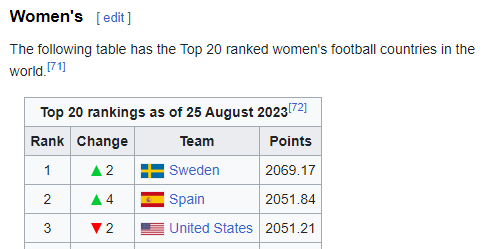

## Findings and Discussions
For the above model, I use the locally downloaded **GPT4ALL Falcon** model to replace the original **OpenAI GPT3.5-turbo** model, it has the following specifications:
- This model has been finetuned from Falcon
- Developed by: Nomic AI
- Model Type: A finetuned Falcon 7B model on assistant style interaction data
- Language(s) (NLP): English
- License: Apache-2
- Finetuned from model [optional]: Falcon

Based on the FIFA Wikipedia website result, I have the following findings:
1. When dealing with pure text data, the answer is mostly correct.
2. When the answer of the data involves with other format (table, etc.), the result is not displaying (ERROR: The prompt size exceeds the context window size and cannot be processed.)